<a href="https://colab.research.google.com/github/rita0435/Aprendizagem_Computacional_TPC/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## 1. Generative classifiers

Consider a classification problem with a target variable $y \in \{0, 1\}$ and input features $\boldsymbol{x} = (x_1\; x_2\; x_3\; x_4)^T$, where $x_1 \in \{0, 1\}$, $x_2 \in \{0, 1\}$, and $(x_3, x_4) \in \mathbb{R}^2$. Further assume that:
- $(x_1, x_2)$ is conditionally independent of $(x_3, x_4)$ given $y$;
- $x_1$ and $x_2$ are **dependent** given $y$;
- $x_3$ and $x_4$ are **dependent** given $y$;
- the conditional distributions of $(x_3, x_4)$ given $y$ are Gaussian.

### 1.1

**a)** Enumerate the parameters of the MAP classifier: $$\hat{y} = \text{arg} \max_{y \in \{0, 1\}} p(y)p(\boldsymbol{x} \mid y),$$ and indicate the dimension of each parameter.

We need to learn the class-conditional probability distributions $p(\mathbf{x}|y)$, which can be written as:

$$
p(x_1, x_2, x_3, x_4 | y) = p(x_1, x_2 | x_3, x_4, y) p(x_3, x_4 | y)
$$

The assumption:
>$(x_1, x_2)$ is conditionally independent of $(x_3, x_4)$ given $y$

allows us to simplify the expression as 

$$
p(x_1, x_2, x_3, x_4 | y) = p(x_1, x_2 | y) p(x_3, x_4 | y)
$$

Of course, we can't decouple the joint conditionals any further since they involve *dependent* variables.

In order to estimate $p(x_1, x_2 | y)$, we need to look at a $2\times 2$ probability table for each possible value $y_k$ of $y$, since $x_1, x_2$ are themselves binary.

For each table, we need to estimate only $4 - 1 = 3$ parameters $\pi_{ijk}$, since we have the additional restriction $\sum_{i,j} \pi_{ijk} = 1$. Thus, this term contributes 2 parameters vectors $\mathbf{\pi_k} \in \mathbb{R}^3$.

On the other hand, we assume that $x_3, x_4$ each follow a Gaussian distribution. In order to study how to estimate $p(x_3, x_4 | y)$, we introduce the notation $\mathbf{u} = [x_3, x_4]^T$ so that $p(\mathbf{u}|y=y_k) \sim \mathcal{N}(\mathbf{\mu_k, \Sigma_k})$ (i.e a 2D Gaussian distribution). Here, we imposed the usual assumption of a *shared covariance matrix* between $x_3, x_4$.

Each mean vector $\mathbf{\mu}_k \in \mathbb{R}^2$ contributes 2 parameters. Moreover, each covariance matrix $\Sigma_k \in \mathbb{R}^{2\times 2}$ accounts for 3 parameters; in general, a $D\times D$ covariance matrix has only $\frac{D(D+1)}{2}$ degrees of freedom, since it is *symmetric*.

> **Conclusion:**
> 16 parameters in total, better described as:
> - $\mathbf{\pi_k} \in \mathbb{R}^3$
> - $\mathbf{\pi_k} \in \mathbb{R}^3$
> - $\Sigma_k \in \mathbb{R}^{2\times 2}$
>
> where $k \in \{0, 1\}$, and as discussed only the upper triangular part of $\Sigma_k$ needs to be estimated.
> We don't need to look at each $k$ separately. If the union $\bigcup_{k=1}^{K}y_k$ spans the whole target space, since $y$ is binary we can simply estimate the posterior $p$ of e.g. positive class $k=1$. The posterior of the negative class will simply be the complement $1 - p$.
>
> This, of course, brings the total of paramters to 8.

**b)** Given a dataset $\{(\boldsymbol{x}^{(i)}, y^{(i)})\}_{i=1}^n$, write the expressions for the maximum likelihood estimates of the parameters enumerated in the previous question.

For the probabilities $\pi_{ijk}$, we have
$$
\hat{\pi}_{ijk} = \frac{\text{# observations with $x_{ij}$ in the subset $y=y_k$}}{\text{# observations in the subset $y=y_k$}}
$$

For the means $\mathbf{\mu}_k$, we have:
$$
\hat{\mathbf{\mu}}_k = \frac{1}{n_k}\sum_{i=1}^{n_k} \mathbf{u}
$$
where $n_k$ denotes the number of observations in the subset $y=y_k$.

For the covariance matrices $\Sigma_k$,
$$
\hat{\Sigma}_k = \frac{1}{n_k}\sum_{i=1}^{n_k}(\mathbf{u} - \hat{\mathbf{\mu}}_k)(\mathbf{u} - \hat{\mathbf{\mu}}_k)^T
$$

### 1.2

Now, you will implement this classifier in Python. The classifier skeleton is provided below in the class `Classifier`. You may implement additional auxiliary methods that you find useful.

In [2]:
import numpy as np
from scipy.stats  import multivariate_normal
# import more packages if you need

class Classifier:
    def fit(self, X, y):
        '''
        Inputs:
            X - np.array with shape (num_examples_train, 4)
            y - np.array with shape (num_examples_train,)
        '''
        ###
        self.num_features = 4
        self.num_classes = 2
        
        self.prob_tables = []
        self.means = []
        self.covs = []
        self.priors = np.zeros(self.num_classes)
        
        N = X.shape[0]
        for c in range(self.num_classes):
            # X: (num_examples, num_features)
            # y: (num_examples, )
            mask = (y == c)
            Xc = X[mask]
            
            Xcd = Xc[:, :2].astype(int) # Discrete features
            Xcc = Xc[:, 2:] # Continuous features
            
            # Estimate parameters for discrete variables
            prob_table = np.zeros((2, 2))
            for i in range(2):
                for j in range(2):
                    temp = (Xcd ^ np.array([i, j])).sum(axis=1) # bitwise XOR is zero if equal
                    mask_ij = (temp == 0) 
                    prob_table[i, j] = mask_ij.sum(axis=0) / Xc.shape[0]
            self.prob_tables.append(prob_table)
            
            # Estimate parameters for continuous variables
            mean = Xcc.mean(axis=0)
            cov = np.cov(Xcc.T)
            self.means.append(mean)
            self.covs.append(cov)
            
            # Estimate the priors
            self.priors[c] = np.sum(mask) / N
        ###
    
    def predict(self, X):
        '''
        Inputs:
            X - np.array with shape (num_examples_test, 4)
        
        Outputs:
            ypred - np.array with shape (num_examples_test,)
            posteriors - np.array with shape (num_examples_test, 2)
        '''
        ###
        # X: (num_examples, num_features)
        # y: (num_examples, )
        posteriors = self.posterior(X)
        print(posteriors.shape)
        preds = np.argmax(posteriors, axis=1)
        return preds, posteriors # pred: (num_examples, )
        ###
    
    def likelihood(self, X):
        Xd = X[:, :2].astype(int) # Discrete features
        Xc = X[:, 2:] # Continuous features
        likelihoods = self.discrete_likelihood(Xd) * self.continuous_likelihood(Xc)
        return likelihoods # likelihoods: (num_examples, num_classes)
        
    def discrete_likelihood(self, X):
        N = X.shape[0]
        likelihoods = np.zeros((N, self.num_classes))
        for c in range(self.num_classes):
            prob_table = self.prob_tables[c]
            likelihoods[:, c] = prob_table[X[:, 0], X[:, 1]]
        return likelihoods # likelihoods: (num_examples, num_classes)
    
    def continuous_likelihood(self, X):
        N = X.shape[0]
        likelihoods = np.zeros((N, self.num_classes))
        for c in range(self.num_classes):
            likelihoods[:, c] = multivariate_normal.pdf(
                X,
                mean=self.means[c],
                cov=self.covs[c]
            )
        return likelihoods # likelihoods: (num_examples, num_classes)
    
    def posterior(self, X):
        likelihoods = self.likelihood(X)
        posteriors = self.priors.reshape(1, self.num_classes) * likelihoods # (1, num_classes) x (num_examples, num_classes)
        posteriors /= posteriors.sum(axis=1)[:, np.newaxis] # normalize posteriors
        return posteriors # posteriors: (num_examples, num_classes)

**N.B.:** In both a) and b), you should avoid for loops as much as possible by using vectorized NumPy operations and broadcasting.

**a)** Implement the `fit` method, which receives as input two `np.array`s:
- `X`, which contains the 4-dimensional training input examples $\boldsymbol{x}^{(i)}$, one per row;
- `y`, which contains the corresponding training labels $y^{(i)} \in \{0,1\}$, one per row.

This method should compute the maximum likelihood estimates of the model parameters and store them as class attributes.

**b)** Implement the `predict` method, which receives as input one `np.array`:
- `X`, which contains the 4-dimensional examples $\boldsymbol{x}^{(i)}$ to be classified, one per row.

This function should return two `np.array`s:
- `ypred`, which should contain the predicted class for each $\boldsymbol{x}^{(i)}$, one per row.
- `posteriors`, which should contain the posterior probabilities of each class given each $\boldsymbol{x}^{(i)}$, one per row.

If you have solved a) and b) correctly, the code below should run without errors and the reported test accuracy should be higher than 80%.

In [3]:
# read the data from file
data = np.genfromtxt('ex1_data.txt')
X, y = data[:, 0:4], data[:, 4].astype(int)

# use the first 400 lines for training and the remaining 100 lines for testing
Xtrain, ytrain = X[0:400], y[0:400]
Xtest, ytest = X[400:], y[400:]

# instantiate the classifier and train it
classifier = Classifier()
classifier.fit(Xtrain, ytrain)

# get the predictions on the test data
ypred, posteriors = classifier.predict(Xtest)
print('Example 0:')
print('  posteriors =', posteriors[0])
print('  predicted class =', ypred[0])
print('  ground-truth class =', ytest[0])
print()
print('Example 1:')
print('  posteriors =', posteriors[1])
print('  predicted class =', ypred[1])
print('  ground-truth class =', ytest[1])
print()
print('Example 2:')
print('  posteriors =', posteriors[2])
print('  predicted class =', ypred[2])
print('  ground-truth class =', ytest[2])
print()

# compute the accuracy on the test set
acc = np.mean(ypred == ytest)
print(f'Test accuracy = {100.*acc:.1f}%')

(100, 2)
Example 0:
  posteriors = [0.98215382 0.01784618]
  predicted class = 0
  ground-truth class = 0

Example 1:
  posteriors = [0.76798406 0.23201594]
  predicted class = 0
  ground-truth class = 1

Example 2:
  posteriors = [0.03193052 0.96806948]
  predicted class = 1
  ground-truth class = 1

Test accuracy = 92.0%


## 2. Logistic regression

Consider the `heightWeightData.txt` dataset that you have used in the Lab classes. You will use this data to build a Logistic Regression classifier that predicts the sex of an individual given their height and weight.

**a)** Train a Logistic Regression classifier **using only the first 160 rows** of the dataset as training data. You may use Scikit-Learn (`sklearn.linear_model.LogisticRegression`). **Print the values of the learned parameters.**

In [77]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Load data
data = np.loadtxt('heightWeightData.txt', delimiter=',')

# Separate train/test sets
X_train, y_train = data[:160, 1:], data[:160, 0]
X_test, y_test = data[160:, 1:], data[160:, 0]

# Perform hyper-parameter tuning with cross-validation
model = LogisticRegression(random_state=3, solver='liblinear')

param_grid = {
    "penalty": ["l2"],
    "C": np.logspace(-2, 2, 100)
}

grid_search = GridSearchCV(model, param_grid)
grid_search.fit(X_train, y_train)

# Load best performing model
model = grid_search.best_estimator_

# Print trained parameters
print(f'Coefficients = {model.coef_}; Bias = {model.intercept_}')

Coefficients = [[-0.06608927 -0.11613472]]; Bias = [19.67694556]


**b)** Compute the predictions of your model in the remaining 50 rows of the dataset and report the classification accuracy of your model in this test set.

Accuracy = 94.0%


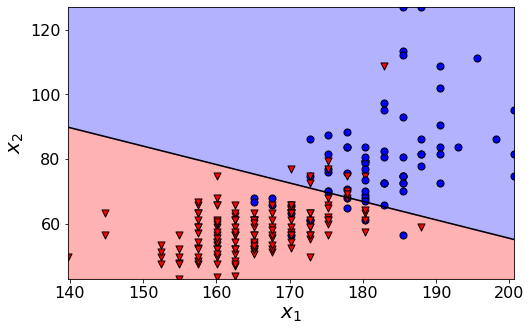

In [111]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model accuracy
accuracy = (y_pred == y_test).sum()/y_pred.size
print(f'Accuracy = {accuracy * 100}%')

# Compute decision boundary 
param = (model.coef_).flatten()
bias = model.intercept_ 

def boundary(x1):
  return -param[0]/param[1] * x1 -bias/param[1]

x1min, x1max = X_train[:, 0].min(), X_train[:, 0].max()
x2min, x2max = X_train[:, 1].min(), X_train[:, 1].max()

x1 = np.linspace(x1min, x1max, 1000)
b = boundary(x1)

# Plot data and boundary
mask = (y_train == 1)
mask2 = (y_test == 1)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.scatter(X_train[mask, 0], X_train[mask, 1],
           color='b', ec='k', s=50, marker='o', zorder=1)
ax.scatter(X_train[~mask, 0], X_train[~mask, 1],
           color='r', ec='k', s=50, marker='v', zorder=1)
ax.scatter(X_test[mask2, 0], X_test[mask2, 1],
           color='b', ec='k', s=50, marker='o', zorder=1)
ax.scatter(X_test[~mask2, 0], X_test[~mask2, 1],
           color='r', ec='k', s=50, marker='v', zorder=1)

ax.plot(x1, b, '-k')
ax.fill_between(x1, x2min*np.ones(x1.size), b, color='r', alpha=0.3, zorder=0)
ax.fill_between(x1, b, x2max*np.ones(x1.size), color='b', alpha=0.3, zorder=0)

ax.set_xlabel(r'$x_1$', fontsize=20)
ax.set_ylabel(r'$x_2$', fontsize=20)
ax.set_xlim(x1min, x1max)
ax.set_ylim(x2min, x2max)
ax.tick_params(labelsize=16)

**c)** Using the parameter values printed in a), write the equation of the decision boundary of your model.

The decision boundary is generally a hyperplane. Since this problem is 2D, it is defined by the following equation:
$$ a_1x_1 + a_2x_2 + b = 0 ↔ $$
$$ x_2 = -\frac{a_1}{a_2}x_1 - \frac{b}{a_2} $$

where $a_1, a_2$ are the parameters returned by ```model.coef_``` and $b$ by ```model.intercept_```